In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv('train_processed_isolation_forest.csv')
df_train.head(10)


,employee_id,employee_seniority_years,num_print_commands,total_printed_pages,num_printed_pages_off_hours,num_color_prints,ratio_color_prints,num_burn_requests,avg_request_classification,num_burn_requests_off_hours,...,high_classification_burn_binary_zscore,is_heavy_burner_binary_zscore,is_heavy_printer_binary_zscore,is_employee_in_origin_country_binary_zscore,is_new_employee_binary_zscore,is_veteran_employee_binary_zscore,date,first_entry_time,last_exit_time,is_malicious
0,829,1.696528,0.906021,0.276392,-0.085613,-0.260469,0.524259,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-05-03,1900-01-01 00:00:00,1900-01-01 00:00:00,0
1,478,1.015628,2.240545,0.363086,-0.085613,-0.260469,1.860413,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-07-24,2025-08-04 08:51:00,2025-08-04 19:17:00,0
2,470,0.334728,-0.619149,-0.359365,-0.085613,-0.260469,-0.568958,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-06-03,2025-08-04 09:02:00,2025-08-04 16:02:00,1
3,1360,0.062368,0.524729,0.363086,-0.085613,-0.260469,1.617476,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-07-15,2025-08-04 07:51:00,2025-08-04 17:13:00,0
4,398,0.743268,0.143436,0.363086,-0.085613,-0.260469,0.159853,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-03-28,1900-01-01 00:00:00,1900-01-01 00:00:00,0
5,181,0.062368,-0.619149,-0.359365,-0.085613,-0.260469,-0.568958,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-04-07,2025-08-04 09:45:00,2025-08-04 14:35:00,0
6,170,-0.618532,-0.237856,-0.185977,-0.085613,-0.260469,0.220588,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,-1.140660,2025-02-26,2025-08-04 07:23:00,2025-08-04 18:00:00,0
7,1010,0.334728,-0.619149,-0.359365,-0.085613,-0.260469,-0.568958,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-06-28,1900-01-01 00:00:00,1900-01-01 00:00:00,0
8,1035,2.377428,-0.619149,-0.359365,-0.085613,-0.260469,-0.568958,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-05-07,2025-08-04 11:21:00,2025-08-04 15:21:00,0
9,1490,1.560348,-0.619149,-0.359365,-0.085613,-0.260469,-0.568958,-0.319184,-0.308479,-0.099078,...,-0.060037,-0.402444,-0.444091,-0.016233,-0.170383,0.876686,2025-02-03,2025-08-04 08:08:00,2025-08-04 18:42:00,0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179928 entries, 0 to 179927
Columns: 118 entries, employee_id to is_malicious
dtypes: float64(113), int64(2), object(3)
memory usage: 162.0+ MB


In [11]:
non_numeric_cols = df_train.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)


Index(['date', 'first_entry_time', 'last_exit_time'], dtype='object')


In [12]:
df_train.drop(['date', 'first_entry_time', 'last_exit_time'], axis=1, inplace=True)


In [13]:
# אימון Isolation Forest
model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42, n_jobs=-1)
model.fit(df_train)


,n_estimators,200
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


# Start Isolation forest

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [15]:

# ------------------------
# 1. Load datasets
# ------------------------
df_train = pd.read_csv('train_processed_isolation_forest.csv')
df_test  = pd.read_csv('test_processed_isolation_forest.csv')
df_eval  = pd.read_csv('val_processed_isolation_forest.csv')


In [16]:

# הורדת עמודות לא רלוונטיות אם קיימות
drop_cols = ['date', 'first_entry_time', 'last_exit_time']
for col in drop_cols:
    for df in [df_train, df_test, df_eval]:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)


In [6]:
df_train.columns[0:70]


Index(['employee_id', 'employee_seniority_years', 'num_print_commands',
       'total_printed_pages', 'num_printed_pages_off_hours',
       'num_color_prints', 'ratio_color_prints', 'num_burn_requests',
       'avg_request_classification', 'num_burn_requests_off_hours',
       'total_burn_volume_mb', 'total_files_burned', 'trip_day_number',
       'total_presence_minutes', 'entry_time_numeric',
       'avg_burn_volume_per_request', 'burn_intensity',
       'classification_variance', 'avg_pages_per_print', 'print_intensity',
       'employee_department_freq', 'employee_campus_cat_Campus A',
       'employee_campus_cat_Campus B', 'employee_campus_cat_Campus C',
       'employee_position_freq', 'is_contractor_binary',
       'employee_classification_freq', 'has_foreign_citizenship_binary',
       'has_criminal_record_binary', 'has_medical_history_binary',
       'num_print_commands_off_hours_freq', 'printed_from_other_binary',
       'print_campuses_freq', 'is_abroad_binary',
       'host

In [7]:
# נסיר פיצרים שקשורים לשייכות העובד למחלקה וכן מאפיינים סטטיים, היות ובמודל הנוכחי אנחנו מעוניינים ללמוד חריגות בהתנהגות העובד כלפי עצמו לאורך זמן
exclude_keywords = [
    'employee_department',
    'employee_position',
    'employee_classification_freq',
    'employee_campus_cat',
    'has_criminal_record',
    'has_medical_history',
    'has_foreign_citizenship',
    'is_contractor',
    'is_employee_in_origin_country',
    'employee_seniority',
    'is_new_employee',
    'is_veteran_employee'
    ]

# הגדרת שמות הפיצרים הרלוונטיים למודל
include_also = [
    'print_vs_department_avg',
    'print_per_minute',
    'prints_percentile',
    'burns_percentile',
    'total_printed_pages_zscore_global',
    'num_print_commands_zscore_global',
    'total_burn_volume_mb_zscore_global'
]

# בניית רשימת הפיצ'רים - כולל גם פרמטרים מהמחסנית השניה
feature_cols = [
    col for col in df.columns
    if (
        (col.endswith('_zscore') or 
         col.endswith('_percentile') or 
         col.endswith('_per_minute') or 
         col.endswith('_vs_department_avg') or
         col.endswith('_quartile') or
         col.endswith('_freq_quartile')) and
        not any(key in col for key in exclude_keywords)
     ) or (col in include_also and col in df.columns)
]

print(len(feature_cols))


49


# new cells 

In [17]:
def add_features(df):
    # בדיקה אם העמודות קיימות
    required_cols = ['total_printed_pages', 'num_print_commands', 'total_burn_volume_mb', 
                     'employee_department_freq', 'total_presence_minutes']
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return df
    
    # Z-scores גלובליים
    for col in ['total_printed_pages', 'num_print_commands', 'total_burn_volume_mb']:
        df[f'{col}_zscore_global'] = (df[col] - df[col].mean()) / df[col].std()
    
    # אחוזונים
    df['prints_percentile'] = df['total_printed_pages'].rank(pct=True)
    df['burns_percentile'] = df['total_burn_volume_mb'].rank(pct=True)
    
    # יחס למחלקה
    df['department_avg_print'] = df.groupby('employee_department_freq')['total_printed_pages'].transform('mean')
    df['print_vs_department_avg'] = df['total_printed_pages'] / df['department_avg_print']
    
    # יחס לנוכחות
    df['print_per_minute'] = df['total_printed_pages'] / df['total_presence_minutes']
    
    return df

In [18]:
df_train = add_features(df_train)
df_test = add_features(df_test)
df_eval = add_features(df_eval)

df_train = df_train[feature_cols]
df_test = df_test[feature_cols]
df_eval = df_eval[feature_cols]

In [19]:

# ------------------------
# 2. Train Isolation Forest
# ------------------------
model = IsolationForest(
    n_estimators=300,
    contamination=0.025,     # שיעור הדגימות החריגות שאתה מצפה
    max_samples='auto',     # דגימה אוטומטית מהדאטה
    random_state=42,
    n_jobs=-1,
    verbose=1
)



In [20]:
model.fit(df_train)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    0.3s remaining:    3.4s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    0.4s finished


IsolationForest(contamination=0.025, n_estimators=300, n_jobs=-1,
                random_state=42, verbose=1)

In [21]:
# ------------------------
# 3. Predict on all sets
# ------------------------
def apply_model(df, name="Set"):
    scores = model.decision_function(df)
    preds = model.predict(df)  # -1 = anomaly, 1 = normal

    df_out = df.copy()
    df_out['anomaly_score'] = scores
    df_out['prediction'] = preds

    print(f"\n📊 Summary for {name}:")
    print(df_out['prediction'].value_counts())
    return df_out

df_train_pred = apply_model(df_train, "TRAIN")
df_test_pred  = apply_model(df_test, "TEST")
df_eval_pred  = apply_model(df_eval, "EVAL")



📊 Summary for TRAIN:
prediction
 1    175429
-1      4499
Name: count, dtype: int64

📊 Summary for TEST:
prediction
 1    58546
-1     1430
Name: count, dtype: int64

📊 Summary for EVAL:
prediction
 1    58490
-1     1486
Name: count, dtype: int64


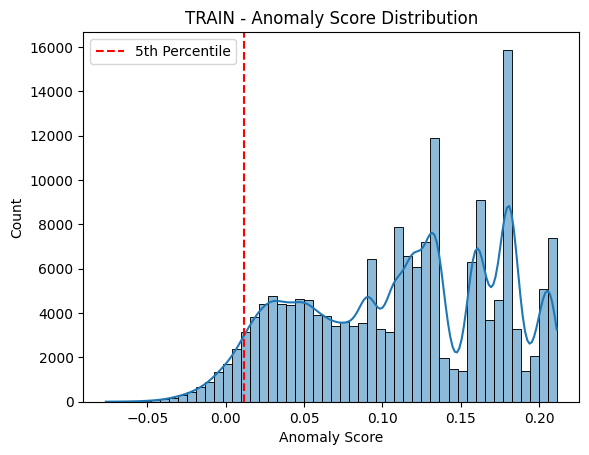

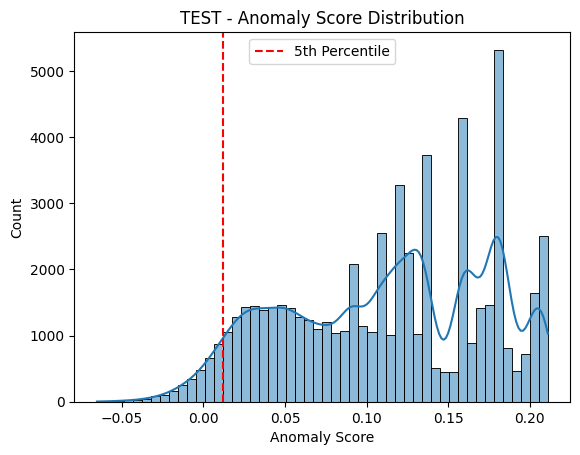

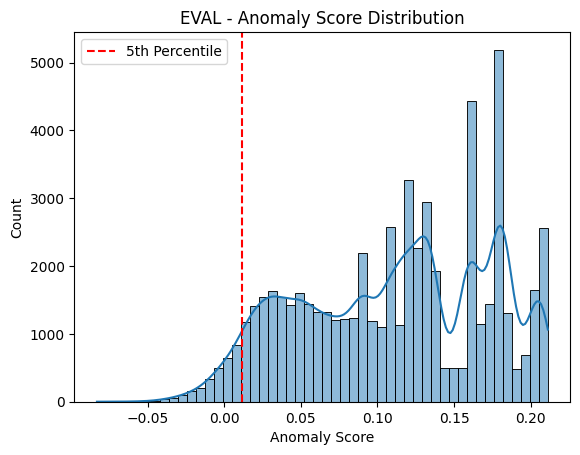

In [24]:

# ------------------------
# 4. Visual Analysis
# ------------------------
def plot_anomaly_distribution(df_pred, title):
    sns.histplot(df_pred['anomaly_score'], bins=50, kde=True)
    plt.title(f"{title} - Anomaly Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Count")
    plt.axvline(x=np.percentile(df_pred['anomaly_score'], 5), color='red', linestyle='--', label='5th Percentile')
    plt.legend()
    plt.show()

plot_anomaly_distribution(df_train_pred, "TRAIN")
plot_anomaly_distribution(df_test_pred, "TEST")
plot_anomaly_distribution(df_eval_pred, "EVAL")



In [25]:
# ------------------------
# 5. Optional: Analyze top anomalies
# ------------------------
def get_top_anomalies(df_pred, top_n=10):
    return df_pred.sort_values(by='anomaly_score').head(top_n)

top_anomalies_train = get_top_anomalies(df_train_pred)
top_anomalies_test  = get_top_anomalies(df_test_pred)

print("\n🕵️‍♂️ Top anomalies in TRAIN:")
print(top_anomalies_train)

print("\n🕵️‍♂️ Top anomalies in TEST:")
print(top_anomalies_test)



🕵️‍♂️ Top anomalies in TRAIN:
        num_print_commands_zscore  total_printed_pages_zscore  \
106864                   1.668607                    0.363086   
41928                    2.049899                    0.363086   
52834                    1.287314                    0.160800   
98037                    2.240545                    0.363086   
161833                  -0.237856                   -0.185977   
47309                    0.906021                    0.363086   
25349                    1.668607                    0.363086   
81869                    2.240545                   -0.243773   
65743                    0.524729                    0.363086   
72495                    0.143436                    0.103004   

        num_printed_pages_off_hours_zscore  num_color_prints_zscore  \
106864                           -0.085613                -0.260469   
41928                            -0.085613                -0.260469   
52834                            -0.0856

In [26]:
df_train_pred['prediction'].value_counts()


prediction
 1    175429
-1      4499
Name: count, dtype: int64

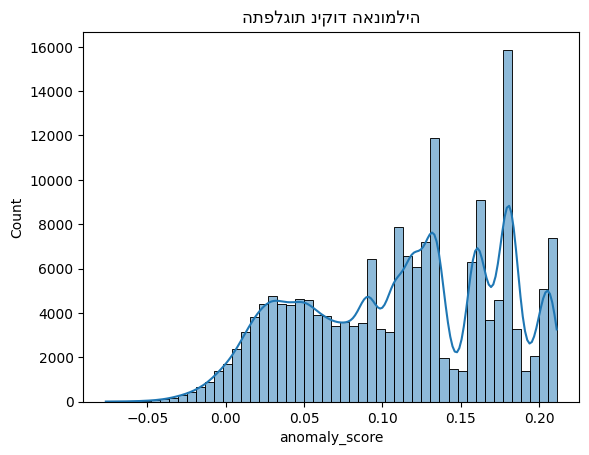

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_train_pred['anomaly_score'], bins=50, kde=True)
plt.title("התפלגות ניקוד האנומליה")
plt.show()


# EVALUATE MODEL

In [22]:
# 1. Train the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
model.fit(df_train)

# 2. Predict
def apply_model(df):
    df_out = df.copy()
    df_out['anomaly_score'] = model.decision_function(df)
    df_out['prediction'] = model.predict(df)
    return df_out

df_train_pred = apply_model(df_train)
df_test_pred = apply_model(df_test)
df_eval_pred = apply_model(df_eval)

# קריאת הקבצים המקוריים עם העמודה is_malicious
df_train_original = pd.read_csv('train_processed_isolation_forest.csv')
df_test_original = pd.read_csv('test_processed_isolation_forest.csv')
df_eval_original = pd.read_csv('val_processed_isolation_forest.csv')

# הוספת העמודה is_malicious לכל DataFrame לפני הקריאה לפונקציית evaluate_set
df_train_pred['is_malicious'] = df_train_original['is_malicious']
df_test_pred['is_malicious'] = df_test_original['is_malicious']
df_eval_pred['is_malicious'] = df_eval_original['is_malicious']

# 3. Evaluate
def evaluate_set(df, name="SET"):
    y_true = df['is_malicious']
    y_pred = df['prediction'].replace({1: 0, -1: 1})
    print(f"\n📊 Evaluation for {name}:")
    print(classification_report(y_true, y_pred, digits=4))
    print("✅ Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("🎯 Accuracy:", accuracy_score(y_true, y_pred))
    print("🎯 Precision:", precision_score(y_true, y_pred))
    print("🎯 Recall:", recall_score(y_true, y_pred))
    print("🎯 ROC AUC:", roc_auc_score(y_true, y_pred))

evaluate_set(df_train_pred, "TRAIN")
evaluate_set(df_test_pred, "TEST")
evaluate_set(df_eval_pred, "EVAL")



📊 Evaluation for TRAIN:
              precision    recall  f1-score   support

           0     0.9773    0.9523    0.9646    175415
           1     0.0704    0.1403    0.0937      4513

    accuracy                         0.9320    179928
   macro avg     0.5238    0.5463    0.5292    179928
weighted avg     0.9546    0.9320    0.9428    179928

✅ Confusion Matrix:
[[167051   8364]
 [  3880    633]]
🎯 Accuracy: 0.9319505580009781
🎯 Precision: 0.0703567855951984
🎯 Recall: 0.14026146687347663
🎯 ROC AUC: 0.5462901268751557

📊 Evaluation for TEST:
              precision    recall  f1-score   support

           0     0.9774    0.9528    0.9649     58472
           1     0.0717    0.1416    0.0952      1504

    accuracy                         0.9325     59976
   macro avg     0.5245    0.5472    0.5301     59976
weighted avg     0.9546    0.9325    0.9431     59976

✅ Confusion Matrix:
[[55713  2759]
 [ 1291   213]]
🎯 Accuracy: 0.9324729891956782
🎯 Precision: 0.07166890982503364
🎯 Re

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

# 1. טען את הקבצים עם עמודת is_malicious
df_train = pd.read_csv('train_processed_isolation_forest.csv')
df_test = pd.read_csv('test_processed_isolation_forest.csv')
df_eval = pd.read_csv('val_processed_isolation_forest.csv')

# 2. הגדרת משתני X ו־y
X_train = df_train.drop(columns=['is_malicious'])
y_train = df_train['is_malicious']

X_test = df_test.drop(columns=['is_malicious'])
y_test = df_test['is_malicious']

X_eval = df_eval.drop(columns=['is_malicious'])
y_eval = df_eval['is_malicious']

# 3. איזון הדאטה עם SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 4. הגדרת המודל - Random Forest
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 5. אימון
model.fit(X_train_balanced, y_train_balanced)

# 6. פונקציית הערכה
def evaluate_set(X, y, name="SET"):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    print(f"\n📊 Evaluation for {name}:")
    print(classification_report(y, y_pred, digits=4))
    print("✅ Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("🎯 Accuracy:", accuracy_score(y, y_pred))
    print("🎯 Precision:", precision_score(y, y_pred))
    print("🎯 Recall:", recall_score(y, y_pred))
    print("🎯 ROC AUC:", roc_auc_score(y, y_pred_proba))

# 7. הרצת הערכות על שלושת הסטים
evaluate_set(X_train, y_train, "TRAIN")
evaluate_set(X_test, y_test, "TEST")
evaluate_set(X_eval, y_eval, "EVAL")


ImportError: cannot import name 'parse_version' from 'sklearn.utils' (/home/user/Documents/dev/ready/ml-dl--ready-course/finallyProject/isolation-forest/.env3/lib/python3.12/site-packages/sklearn/utils/__init__.py)

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
print("✅ הכל תקין - ניתן להשתמש ב-SMOTE ו-Random Forest")


ImportError: cannot import name 'parse_version' from 'sklearn.utils' (/home/user/Documents/dev/ready/ml-dl--ready-course/finallyProject/isolation-forest/.env3/lib/python3.12/site-packages/sklearn/utils/__init__.py)

In [29]:

df = df_train
df['prints_per_day'] = df['total_printed_pages'] / df['num_days_present']
df['prints_per_day'].fillna(0, inplace=True)

df['print_off_hours_ratio'] = df['num_print_commands_off_hours'] / df['num_print_commands']
df['print_off_hours_ratio'].fillna(0, inplace=True)

df['work_hours_deviation'] = df['total_presence_minutes'] - 480


KeyError: 'total_printed_pages'